# Task 0: Colored-MNIST Dataset

I'm creating a biased MNIST dataset where each digit has a "dominant" color 95% of the time in train/val, but the test set has inverted colors (0s are never red, etc). This lets me study how models learn spurious correlations.

In [32]:
import sys
from pathlib import Path

ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils.seed import seed_everything, SeedConfig
from src.data import generate_colored_mnist, load_meta, get_color_palette, get_color_names, make_dominant_color_map
from src.data import load_split, compute_overall_correlation, compute_empirical_correlation, get_dataloaders

SEED = 42
DATA_DIR = ROOT / "data" / "colored_mnist"
seed_everything(SeedConfig(seed=SEED))

print(f"data will be at: {DATA_DIR}")

data will be at: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist


## Generate the dataset

In [33]:
# generate if it doesnt exist yet
if not (DATA_DIR / "meta.json").exists():
    generate_colored_mnist(DATA_DIR, seed=SEED, corr=0.95, test_mode="inverted")
else:
    print("dataset already exists, skipping generation")

meta = load_meta(DATA_DIR)
print(f"\nseed: {meta['seed']}, correlation: {meta['correlation']}")
print(f"splits: {meta['splits']}")

Generating Colored-MNIST dataset...
  Output: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist
  Seed: 42
  Correlation: 0.95
  Test mode: inverted

Loading MNIST...
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:14<00:00, 666kB/s] 


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 101kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 703kB/s] 


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.64MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Split sizes: train=54000, val=6000, test=10000

Generating train split...
  Saved train: 54000 samples → /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/train.pt
Generating val split...
  Saved val: 6000 samples → /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/val.pt
Generating test_hard split...
  Saved test_hard: 10000 samples → /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/test_hard.pt
  Saved metadata → /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/meta.json

Verification:
  train     :  95.0% dominant (expected ~95%) ✓
  val       :  95.3% dominant (expected ~95%) ✓
  test_hard :   0.0% dominant (expected ~0%) ✓

Done! Dataset saved to: /Users/lohithkola/Desktop/proj

## Verify correlation stats

This is the important part - I need to make sure train/val have ~95% dominant color and test_hard has ~0%.

In [34]:
dominant_map = make_dominant_color_map()
color_names = get_color_names()

print("overall correlation (should be ~95% for train/val, ~0% for test):")
for split in ["train", "val", "test_hard"]:
    data = load_split(DATA_DIR, split)
    corr = compute_overall_correlation(data["labels"], data["color_ids"], dominant_map)
    print(f"  {split}: {corr*100:.1f}%")

overall correlation (should be ~95% for train/val, ~0% for test):
  train: 95.0%
  val: 95.3%
  test_hard: 0.0%


In [35]:
# per-digit breakdown for train
train_data = load_split(DATA_DIR, "train")
per_digit = compute_empirical_correlation(train_data["labels"], train_data["color_ids"], dominant_map)
print("per-digit correlation (train):")
for d, c in per_digit.items():
    print(f"  digit {d} ({color_names[d]}): {c*100:.1f}%")

per-digit correlation (train):
  digit 0 (red): 94.9%
  digit 1 (green): 95.3%
  digit 2 (blue): 94.8%
  digit 3 (yellow): 94.8%
  digit 4 (purple): 95.1%
  digit 5 (cyan): 95.2%
  digit 6 (orange): 94.9%
  digit 7 (pink): 95.5%
  digit 8 (brown): 95.0%
  digit 9 (gray): 94.9%


## Sample images

Some samples to make sure the colorization looks right.

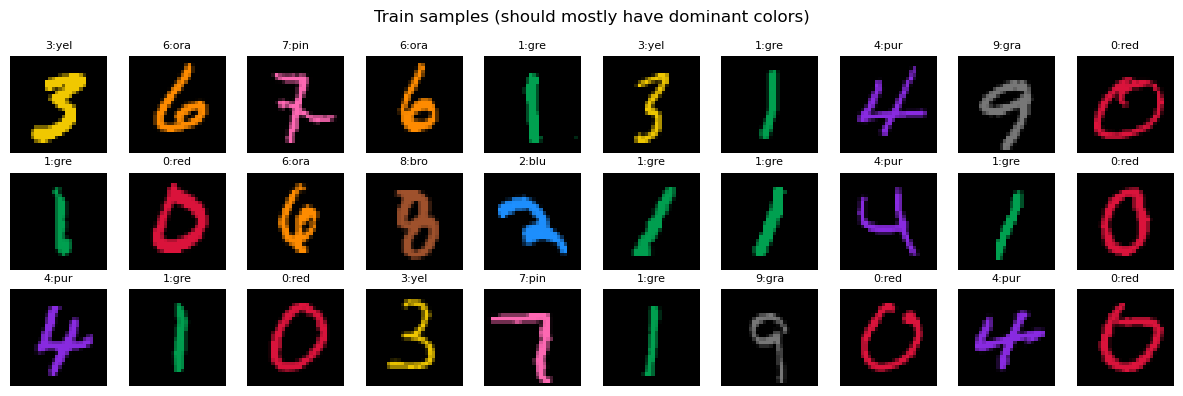

In [36]:
def show_samples(data, title, n=30):
    fig, axes = plt.subplots(3, 10, figsize=(12, 4))
    for i, ax in enumerate(axes.flat):
        if i >= n:
            ax.axis('off')
            continue
        img = data["images"][i].permute(1, 2, 0).numpy()
        label = int(data["labels"][i])
        color_id = int(data["color_ids"][i])
        ax.imshow(img)
        ax.set_title(f"{label}:{color_names[color_id][:3]}", fontsize=8)
        ax.axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_data, "Train samples (should mostly have dominant colors)")

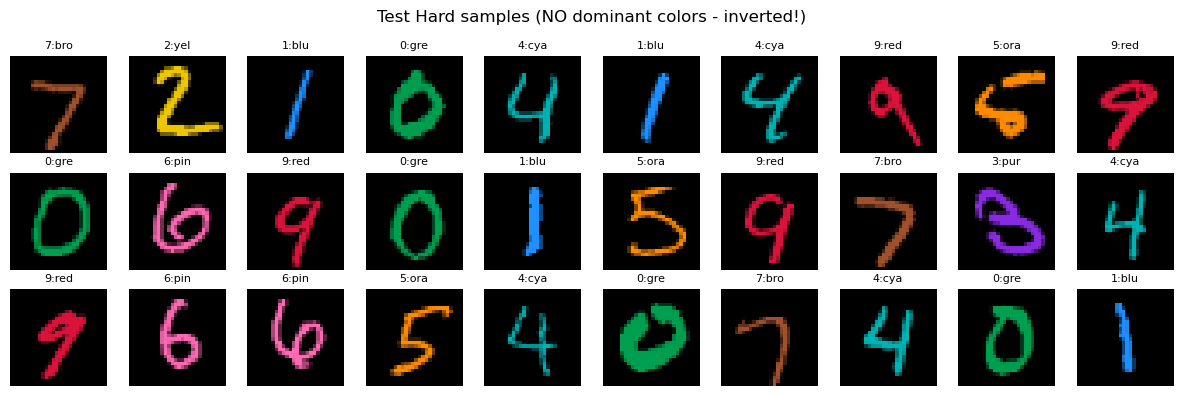

In [37]:
test_data = load_split(DATA_DIR, "test_hard")
show_samples(test_data, "Test Hard samples (NO dominant colors - inverted!)")

## Quick dataloader test

In [38]:
loaders = get_dataloaders({"root": str(DATA_DIR), "batch_size": 64, "num_workers": 0})
print("dataloaders:")
for name, loader in loaders.items():
    print(f"  {name}: {len(loader.dataset)} samples, {len(loader)} batches")

# quick check
imgs, labels = next(iter(loaders["train"]))
print(f"\nbatch shape: {imgs.shape}, range: [{imgs.min():.2f}, {imgs.max():.2f}]")

dataloaders:
  train: 54000 samples, 844 batches
  val: 6000 samples, 94 batches
  test_hard: 10000 samples, 157 batches

batch shape: torch.Size([64, 3, 28, 28]), range: [0.00, 1.00]


## Done

Dataset looks good. Train/val have ~95% dominant color, test_hard has 0%. The colors are applied to the strokes (not flat background). Ready for Task 1.